In [1]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.size'] = '25'
mpl.rcParams['xtick.labelsize'] = '20'
mpl.rcParams['ytick.labelsize'] = '20'

In [2]:
from astropy.table import Table
import astropy.units as u
import astropy.constants as c

In [170]:
import sncosmo
from astropy.cosmology import FlatLambdaCDM
import sys
sys.path.append('../spectroscopy/')
from dust_extinction import calALambda

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
distmod = cosmo.distmod(z=0.0307)
distmod

<Quantity 35.64481825 mag>

In [110]:
leff_g = 4722.74 #AA
leff_r = 6339.61 #AA
rv = 3.1
ebv = 0.404
calALambda(leff_g, rv, ebv), calALambda(leff_r, rv, ebv)

(1.516916147247459, 1.0017554354796698)

In [167]:
lc = Table.read('ZTF20aayhacx_fnu.csv')
lc['mjd'] = lc['jd'] - 2400000.5
lc = lc[np.where((lc['mjd'] > 58900) & (lc['mjd'] < 59100))]

lc = lc[lc['fnu_microJy'] > lc['fnu_microJy_unc'] * 0.2]
lc1 = lc.copy()
lc_g = lc1[lc1['passband'] == 'ZTF_g']
lc_r = lc1[lc1['passband'] == 'ZTF_r']
lc_g['fnu_microJy'] = lc_g['fnu_microJy']
lc_g['fnu_microJy_uncmicroJy'] = lc_g['fnu_microJy_unc']
lc_r['fnu_microJy'] = lc_r['fnu_microJy']
lc_r['fnu_microJy_uncmicroJy'] = lc_r['fnu_microJy_unc']

In [164]:
time = lc['mjd']
flux = lc['fnu_microJy']
fluxerr = lc['fnu_microJy_unc']
zp = np.ones_like(time) * 23.9  #AB magnitude for 1 micro Jansky
zpsys = ['ab' for i in range(len(time))]


def passband(b):
    if b == 'ZTF_g':
        return 'ztfg'
    if b == 'ZTF_r':
        return 'ztfr'
    if b == 'ZTF_i':
        return 'ztfi'


band = [passband(b) for b in lc['passband']]
data = Table([time, band, flux, fluxerr, zp, zpsys],
             names=['time', 'band', 'flux', 'fluxerr', 'zp', 'zpsys'])

In [168]:
lc_g['mag'] = -2.5 * np.log10(lc_g['fnu_microJy']) + 23.9 - distmod.value - calALambda(leff_g, rv, ebv)
lc_g['mag_unc'] = -2.5 * np.log10(
    lc_g['fnu_microJy'] / (lc_g['fnu_microJy'] + lc_g['fnu_microJy_unc'])) / 2
lc_r['mag'] = -2.5 * np.log10(lc_r['fnu_microJy']) + 23.9 - distmod.value - calALambda(leff_r, rv, ebv)
lc_r['mag_unc'] = -2.5 * np.log10(
    lc_r['fnu_microJy'] / (lc_r['fnu_microJy'] + lc_r['fnu_microJy_unc'])) / 2

Text(0, 0.5, '$\\mathrm{M}$')

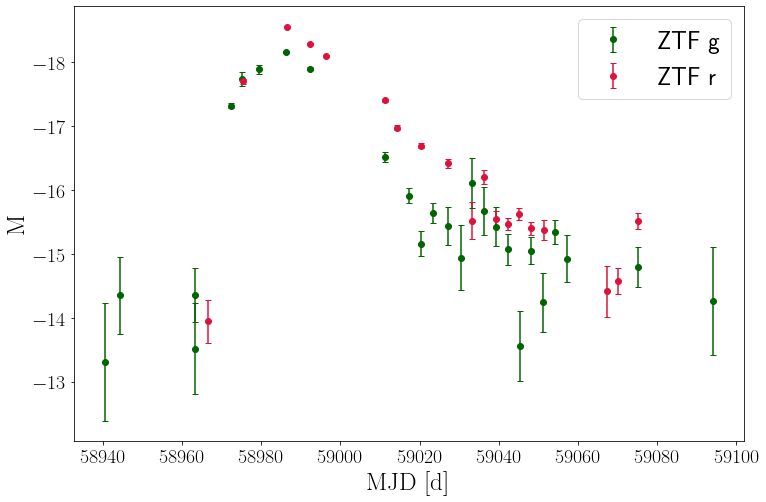

In [169]:
plt.figure(figsize=(12, 8))
plt.errorbar(lc_g['mjd'],
             lc_g['mag'],
             yerr=lc_g['mag_unc'],
             fmt='o',
             capsize=3,
             color='darkgreen', label='ZTF g')
plt.errorbar(lc_r['mjd'],
             lc_r['mag'],
             yerr=lc_r['mag_unc'],
             fmt='o',
             capsize=3,
             color='crimson', label='ZTF r')
#plt.ylim(17, 24)
plt.legend()
plt.gca().invert_yaxis()
plt.xlabel(r'$\mathrm{MJD\ [d]}$')
plt.ylabel(r'$\mathrm{M}$')

In [80]:
# create a model
dust = sncosmo.CCM89Dust()
model = sncosmo.Model(source='salt2',
                      effects=[dust, dust],
                      effect_names=['host', 'mw'],
                      effect_frames=['rest', 'obs'])

# set the model's redshift
model.set(z=0.0307)

# set the model's galactic extinction
model.set(mwebv=0.404)
# run the fit
result, fitted_model = sncosmo.fit_lc(
    data, model, ['t0', 'x0', 'x1', 'c'])  # parameters of model to vary

In [81]:
print("Number of chi^2 function calls:", result.ncall)
print("Number of degrees of freedom in fit:", result.ndof)
print("chi^2 value at minimum:", result.chisq)
print("model parameters:", result.param_names)
print("best-fit values:", result.parameters)
print("The result contains the following attributes:\n", result.keys())

Number of chi^2 function calls: 115
Number of degrees of freedom in fit: 29
chi^2 value at minimum: 236.45409406174704
model parameters: ['z', 't0', 'x0', 'x1', 'c', 'hostebv', 'hostr_v', 'mwebv', 'mwr_v']
best-fit values: [ 3.07000000e-02  5.89836186e+04  1.55083669e-03 -1.02055244e+00
  4.23831776e-01  0.00000000e+00  3.10000000e+00  4.04000000e-01
  3.10000000e+00]
The result contains the following attributes:
 dict_keys(['success', 'message', 'ncall', 'chisq', 'ndof', 'param_names', 'parameters', 'vparam_names', 'covariance', 'errors', 'nfit', 'data_mask'])


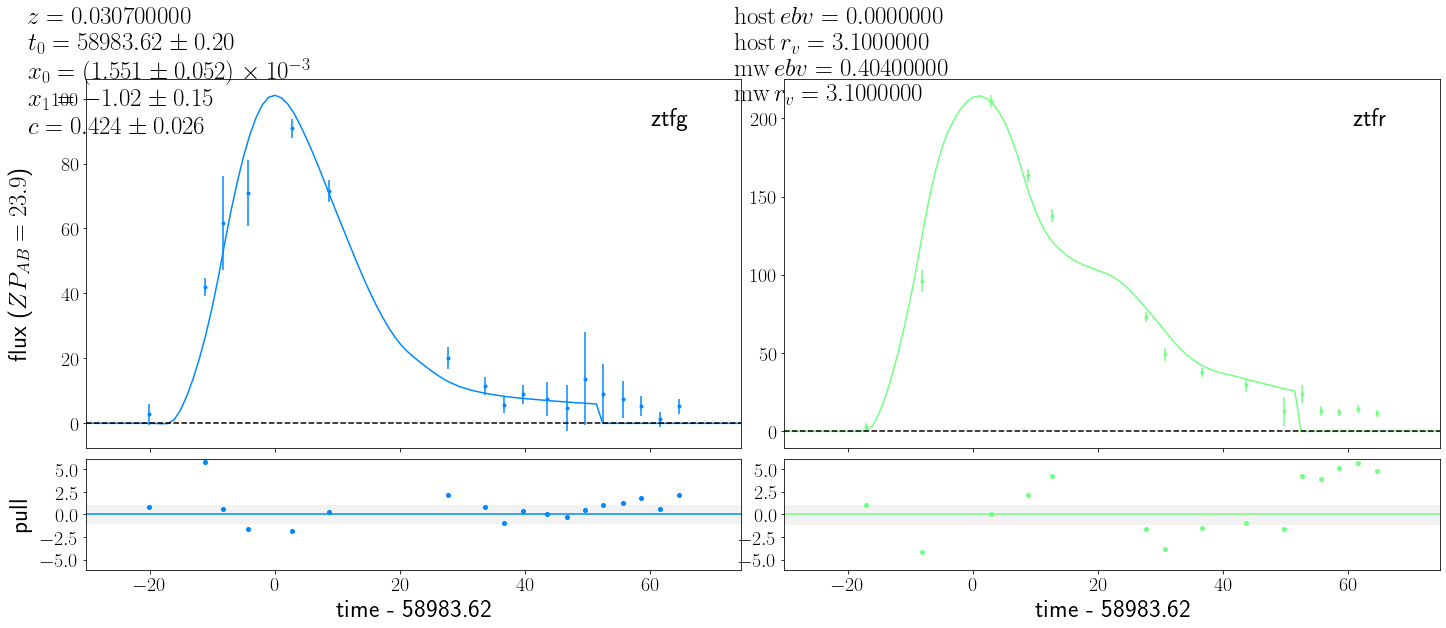

In [82]:
sncosmo.plot_lc(data, model=fitted_model, errors=result.errors, zp=23.9, xfigsize=20);